In [ ]:
from stoned import STONED
import os
import numpy as np 
import random
from random import randrange
import matplotlib.pyplot as plt
import rdkit
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from selfies import encoder, decoder 
from rdkit import RDLogger

import Levenshtein
from Levenshtein import distance, editops

from PIL import Image
from rdkit.Chem import RDConfig
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

RDLogger.DisableLog('rdApp.*')

In [170]:
"""
Created on Thu Aug 29 11:12:51 2020

@author: akshat
"""

def get_ECFP4(mol):
    ''' Return rdkit ECFP4 fingerprint object for mol

    Parameters: 
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  

    Returns: 
    rdkit ECFP4 fingerprint object for mol
    '''
    return AllChem.GetMorganFingerprint(mol, 2)

def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi
    
    Parameters:
    smi (string) : smile string to be canonicalized 
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful 
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)

def get_fp_scores(smiles_back, target_smi): 
    '''Calculate the Tanimoto fingerprint (ECFP4 fingerint) similarity between a list 
       of SMILES and a known target structure (target_smi). 
       
    Parameters:
    smiles_back   (list) : A list of valid SMILES strings 
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    
    Returns: 
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)
    fp_target = get_ECFP4(target)
    for item in smiles_back: 
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_ECFP4(mol)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores


def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie
    
    Parameters: 
    selfie (string) : A selfie string - representing a molecule 
    
    Example: 
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']
    
    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.

    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)
    
    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True)


def get_random_smiles(smi, num_random_samples): 
    ''' Obtain 'num_random_samples' non-unique SMILES orderings of smi
    
    Parameters:
    smi (string)            : Input SMILES string (needs to be a valid molecule)
    num_random_samples (int): Number fo unique different SMILES orderings to form 
    
    Returns:
    randomized_smile_orderings (list) : list of SMILES strings
    '''
    mol = Chem.MolFromSmiles(smi)
    if mol == None: 
        raise Exception('Invalid starting structure encountered')
    randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]
    randomized_smile_orderings  = list(set(randomized_smile_orderings)) # Only consider unique SMILE strings
    return randomized_smile_orderings


def obtain_path(starting_smile, target_smile, filter_path=False): 
    ''' Obtain a path/chemical path from starting_smile to target_smile
    
    Parameters:
    starting_smile (string) : SMILES string (needs to be a valid molecule)
    target_smile (int)      : SMILES string (needs to be a valid molecule)
    filter_path (bool)      : If True, a chemical path is returned, else only a path
    
    Returns:
    path_smiles (list)                  : A list of smiles in path between starting_smile & target_smile
    path_fp_scores (list of floats)     : Fingerprint similarity to 'target_smile' for each smiles in path_smiles
    smiles_path (list)                  : A list of smiles in CHEMICAL path between starting_smile & target_smile (if filter_path==False, then empty)
    filtered_path_score (list of floats): Fingerprint similarity to 'target_smile' for each smiles in smiles_path (if filter_path==False, then empty)
    '''
    starting_selfie = encoder(starting_smile)
    target_selfie = encoder(target_smile)
    
    starting_selfie_chars = get_selfie_chars(starting_selfie)
    target_selfie_chars = get_selfie_chars(target_selfie)
    
    # Compute edit operations at the token level
    ops = editops(starting_selfie_chars, target_selfie_chars)
    
    path = {}
    path[0] = starting_selfie_chars.copy()
    current_selfie = starting_selfie_chars.copy()
    path_step = 0

    #Debug
    # print(f"Starting SELFIE: {starting_selfie}")
    # print(f"Target SELFIE: {target_selfie}")
    # print(f"Starting SELFIE Chars: {starting_selfie_chars}")
    # print(f"Operations: {ops}")
    
    # Apply edit operations
    offset = 0  # Track index shifts dynamically

    # Apply edit operations
    # shuffle the order of the operations
    for op in ops:
        path_step += 1
        operation, idx_start, idx_target = op

        adjusted_idx_start = idx_start + offset
        
        if operation == 'replace':
            if adjusted_idx_start < len(current_selfie) and idx_target < len(target_selfie_chars):
                current_selfie[adjusted_idx_start] = target_selfie_chars[idx_target]
        elif operation == 'insert':
            if idx_target < len(target_selfie_chars):
                current_selfie.insert(adjusted_idx_start, target_selfie_chars[idx_target])
                offset += 1  # Increment offset due to insertion
        elif operation == 'delete':
            if adjusted_idx_start < len(current_selfie):
                del current_selfie[adjusted_idx_start]
                offset -= 1  # Decrement offset due to deletion
        
        # Record the new state
        path[path_step] = current_selfie.copy()
        # print(path_step, current_selfie)
    
    # Collapse path to make them into SELFIE strings
    paths_selfies = []
    for i in range(len(path)):
        selfie_str = ''.join(x for x in path[i] if x != ' ') 
        paths_selfies.append(selfie_str)

    if paths_selfies[-1] != target_selfie: 
        raise Exception("Unable to discover target structure!")
    
    # Obtain similarity scores
    path_smiles = [decoder(x) for x in paths_selfies]
    path_fp_scores = get_fp_scores(path_smiles, target_smile)
    smiles_path = []
    filtered_path_score = []
    
    if filter_path: 
        for i in range(1, len(path_fp_scores)-1): 
            if i == 1: 
                filtered_path_score.append(path_fp_scores[i])
                smiles_path.append(path_smiles[i])
                continue
            if filtered_path_score[-1] < path_fp_scores[i]:
                filtered_path_score.append(path_fp_scores[i])
                smiles_path.append(path_smiles[i])
    
    return path_smiles, path_fp_scores, smiles_path, filtered_path_score


def get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional):
    ''' Obtaining multiple paths/chemical paths from starting_smile to target_smile. 
    
    Parameters:
    starting_smile (string)     : SMILES string (needs to be a valid molecule)
    target_smile (int)          : SMILES string (needs to be a valid molecule)
    num_tries (int)             : Number of path/chemical path attempts between the exact same smiles
    num_random_samples (int)    : Number of different SMILES string orderings to conside for starting_smile & target_smile 
    collect_bidirectional (bool): If true, forms paths from target_smiles-> target_smiles (doubles number of paths)
    
    Returns:
    smiles_paths_dir1 (list): list paths containing smiles in path between starting_smile -> target_smile
    smiles_paths_dir2 (list): list paths containing smiles in path between target_smile -> starting_smile
    '''
    starting_smile_rand_ord = get_random_smiles(starting_smile, num_random_samples=num_random_samples)
    target_smile_rand_ord   = get_random_smiles(target_smile,   num_random_samples=num_random_samples)
    
    smiles_paths_dir1 = [] # All paths from starting_smile -> target_smile
    for smi_start in starting_smile_rand_ord: 
        for smi_target in target_smile_rand_ord: 
            
            if Chem.MolFromSmiles(smi_start) == None or Chem.MolFromSmiles(smi_target) == None: 
                raise Exception('Invalid structures')
                
            for _ in range(num_tries): 
                path, _, _, _ = obtain_path(smi_start, smi_target, filter_path=False)
                smiles_paths_dir1.append(path)
    
    smiles_paths_dir2 = [] # All paths from starting_smile -> target_smile
    if collect_bidirectional == True: 
        starting_smile_rand_ord = get_random_smiles(target_smile, num_random_samples=num_random_samples)
        target_smile_rand_ord   = get_random_smiles(starting_smile,   num_random_samples=num_random_samples)
        
        for smi_start in starting_smile_rand_ord: 
            for smi_target in target_smile_rand_ord: 
                
                if Chem.MolFromSmiles(smi_start) == None or Chem.MolFromSmiles(smi_target) == None: 
                    raise Exception('Invalid structures')
        
                for _ in range(num_tries): 
                    path, _, _, _ = obtain_path(smi_start, smi_target, filter_path=True)
                    smiles_paths_dir2.append(path)
                    
    return smiles_paths_dir1, smiles_paths_dir2

In [171]:
def visualize_paths(paths, starting_molecule, target_molecule):
    '''Visualize paths in 1D using RDKit
    
    Parameters:
    paths (list)           : List of paths containing SMILES strings
    starting_molecule (rdkit.Chem.rdchem.Mol) : Starting molecule
    target_molecule (rdkit.Chem.rdchem.Mol)   : Target molecule
    '''
    sa_scores = []
    qed_scores = []
    mols = [starting_molecule] + [Chem.MolFromSmiles(x) for x in paths] + [target_molecule]
    for mol in mols: 
        sa_scores.append(sascorer.calculateScore(mol))
        qed_scores.append(QED.qed(mol))
    img = Chem.Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 300), legends = [f'SA: {x:.2f}, QED: {y:.2f}' for x, y in zip(sa_scores, qed_scores)])
    return img

In [172]:
adomet_molecule = Chem.SDMolSupplier('examples/TrmD/adomet.sdf')[0]
cp23_molecule = Chem.SDMolSupplier('examples/TrmD/Compound23_docked.sdf')[0]

adomet_smile = Chem.MolToSmiles(adomet_molecule)
cp23_smile = Chem.MolToSmiles(cp23_molecule)

print(adomet_smile)
print(cp23_smile)

C[S@@H](CC[C@H](N)C(=O)O)C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O
CC(C)(CNc1ccc(C(N)=O)cn1)c1cccc(CN)c1


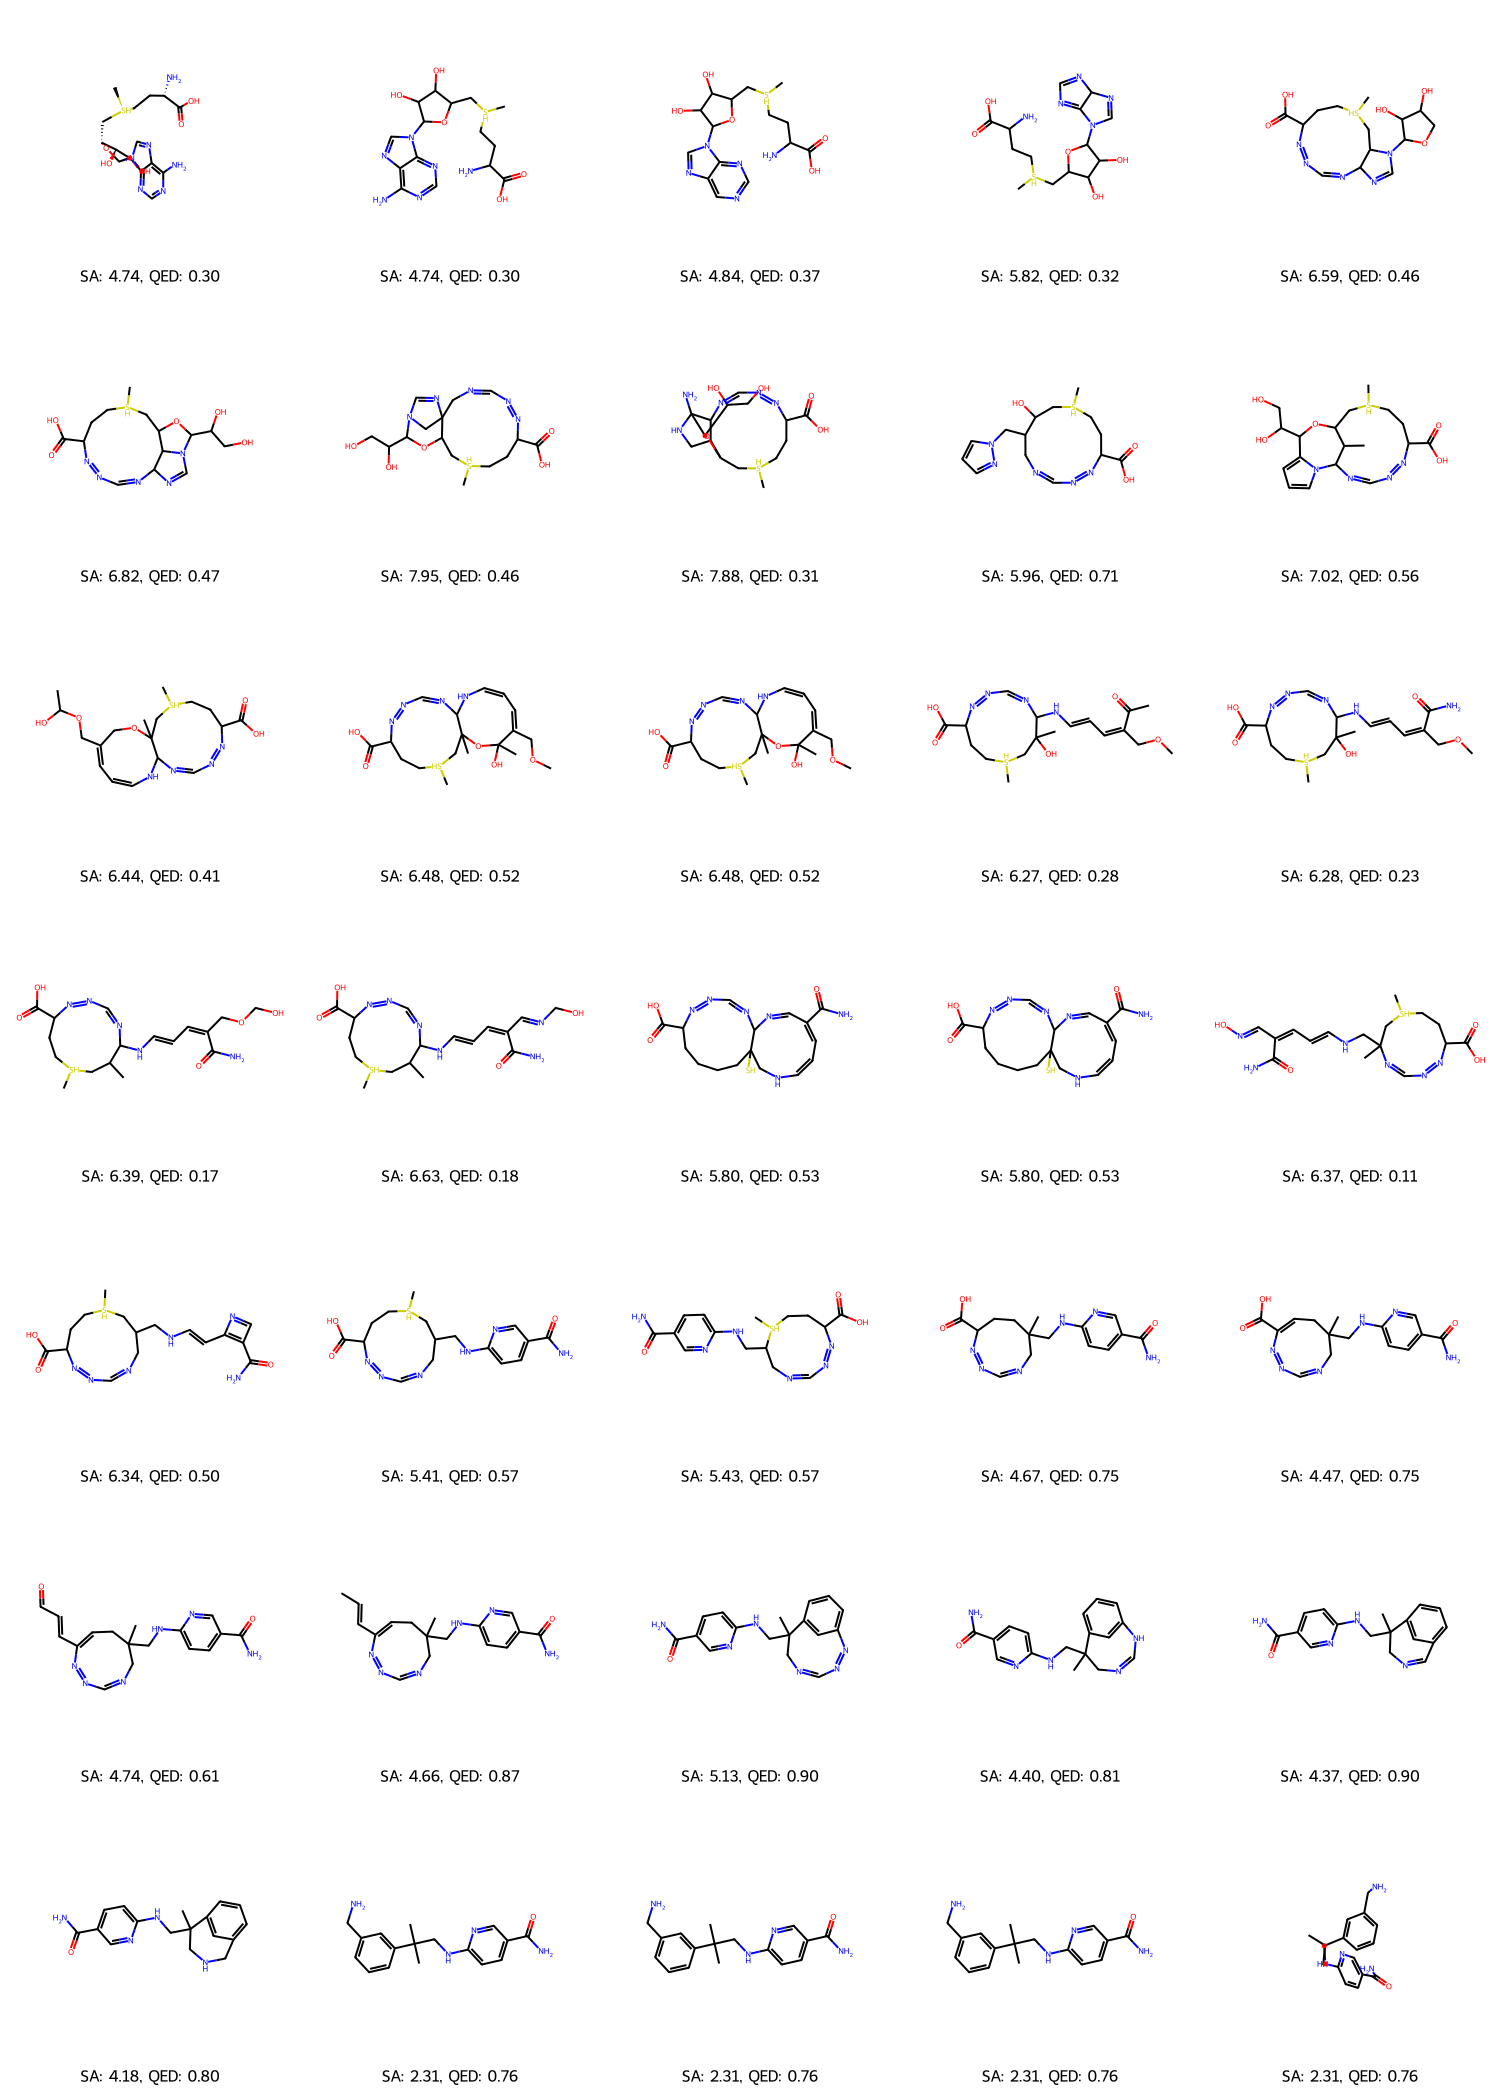

In [173]:
paths, _ = get_compr_paths(adomet_smile, cp23_smile, num_tries=1, num_random_samples=2, collect_bidirectional=False)
visualize_paths(paths[0], adomet_molecule, cp23_molecule)

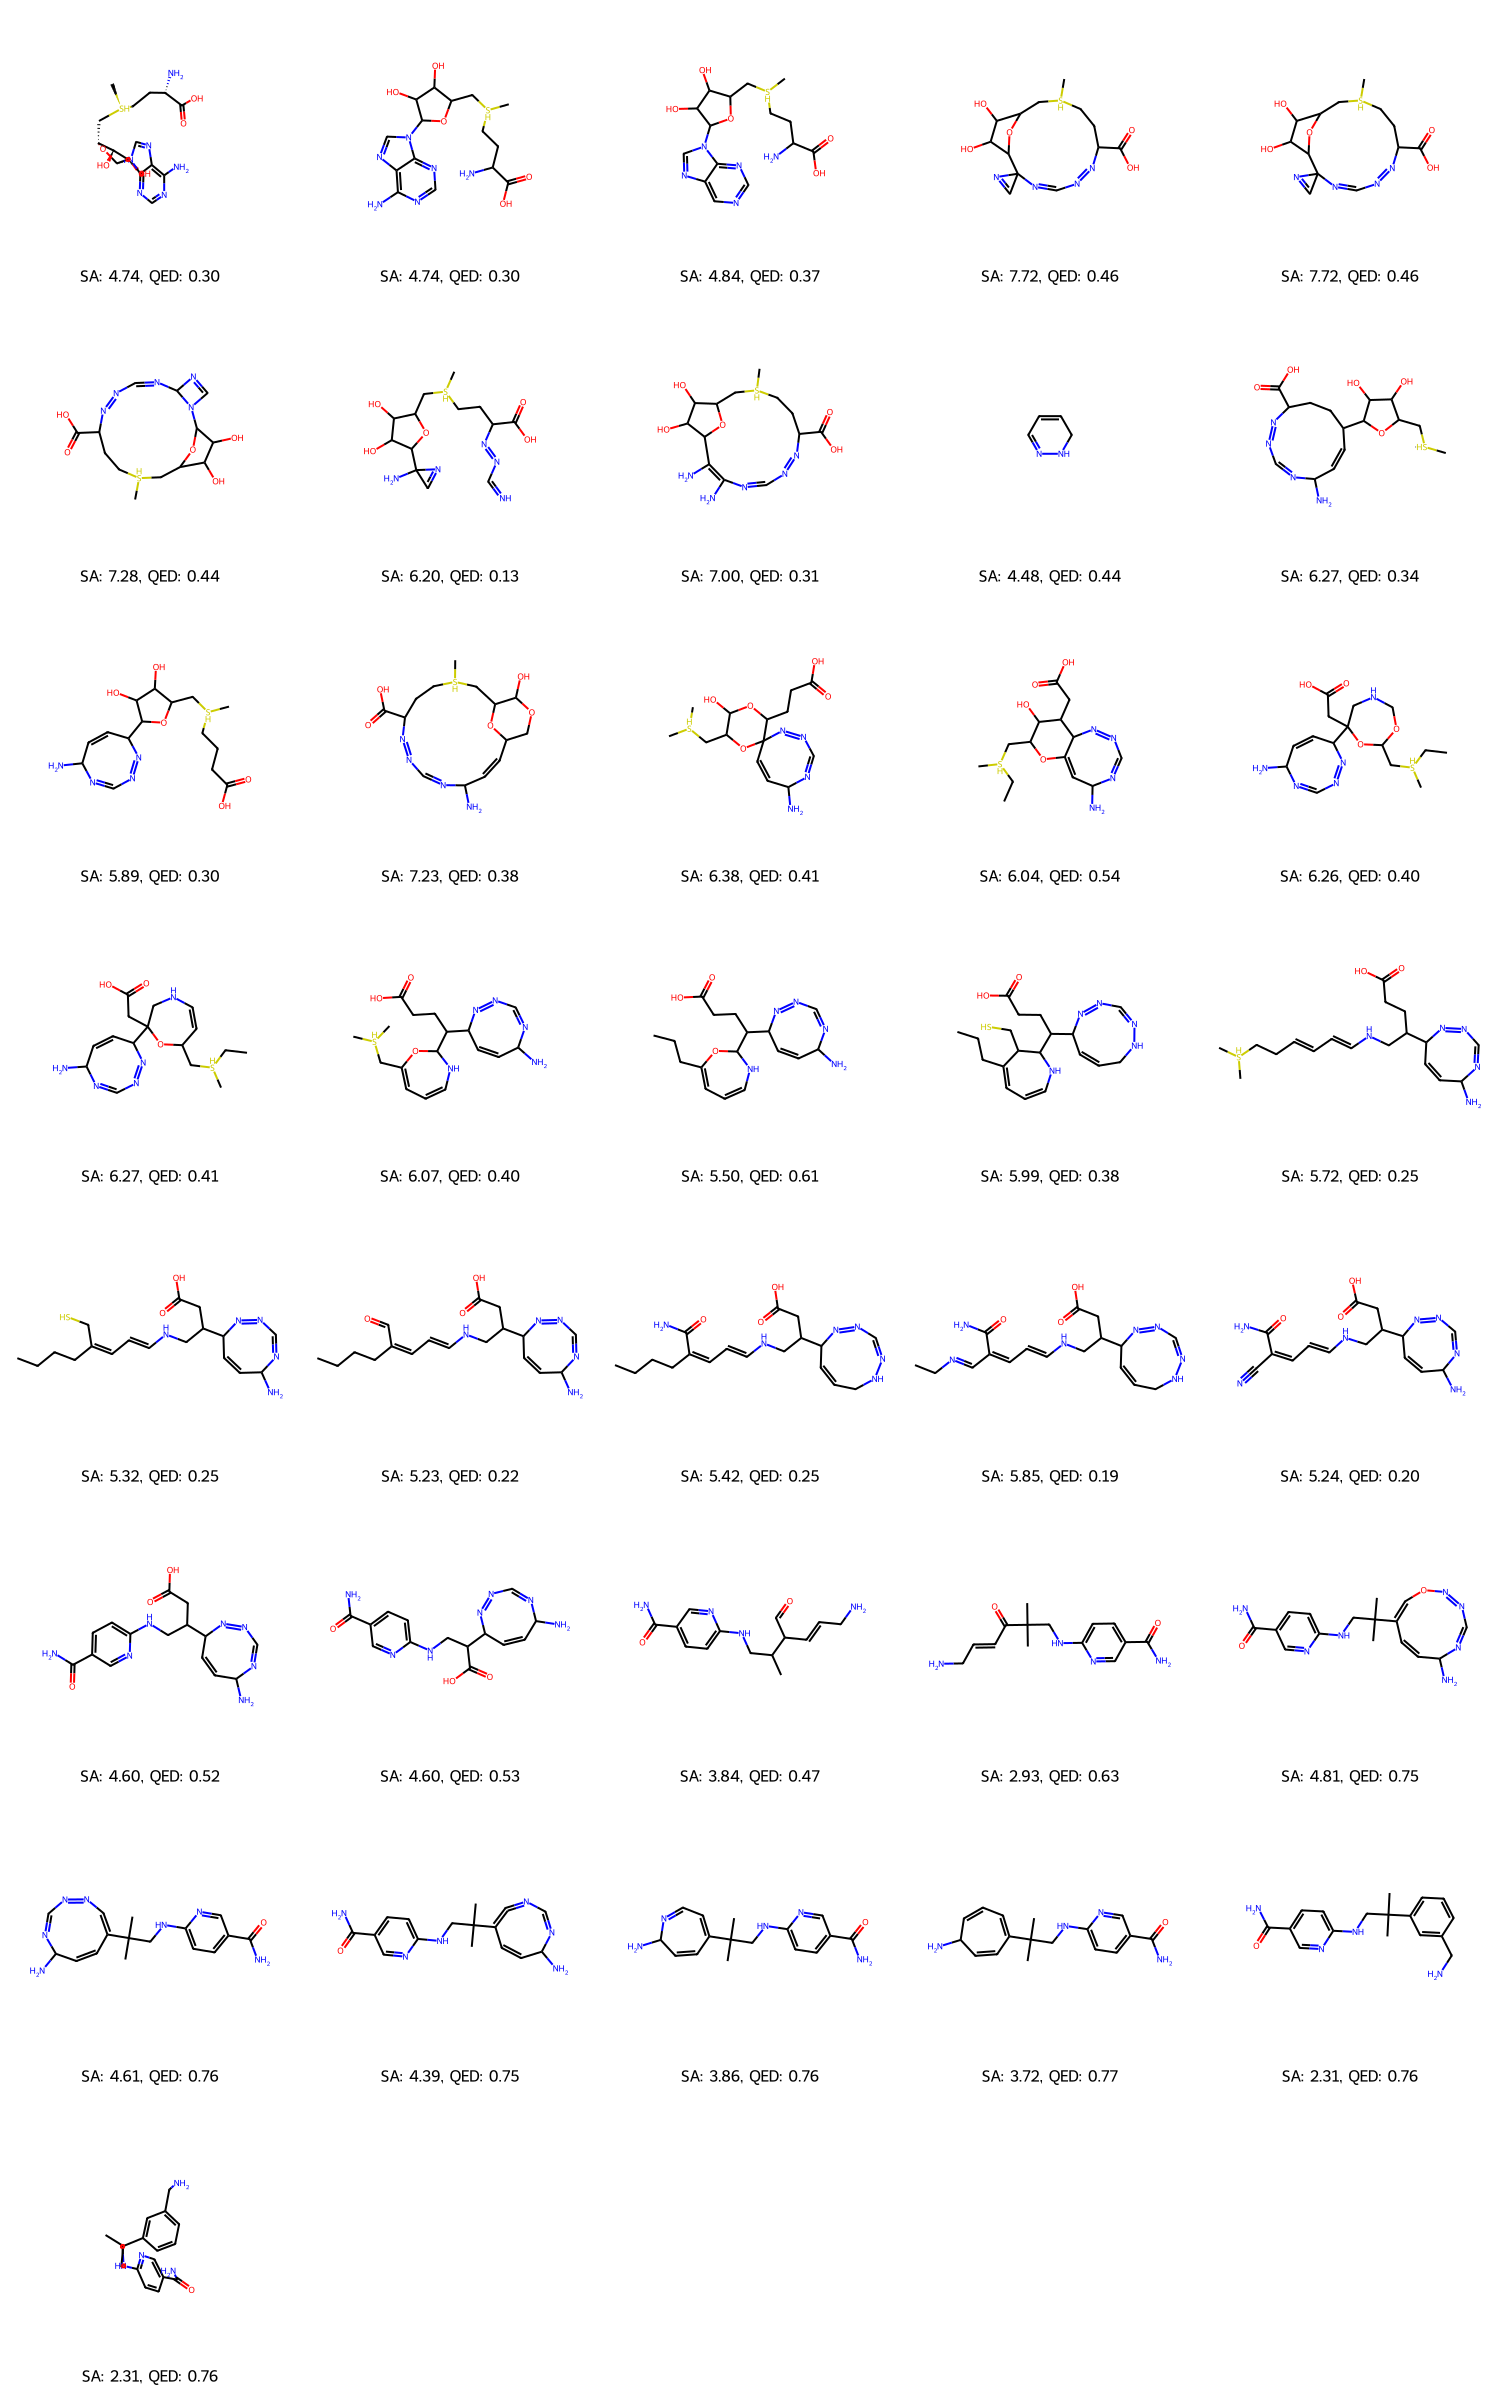

In [174]:
visualize_paths(paths[1], adomet_molecule, cp23_molecule)